In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
## function to skip printing of max_iter warnings

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

# Logistic Regression:

### Introduction:
>Because our variable of interest (churn) is categorical, we are able to apply a logistic regression method
to predict whether a customer ended service with a particular telecom company.

>To understand logistic regression, we must first discuss linear regression.
Linear regression attempts to model the relationship between a dependent variable and one or more explanatory variables,
this model outputs predictions in the form of continuous numerical values. This approach is helpful when attempting to
predict for example, the sale price of a home in a certain area, or the test score of a student who studied for a
certain number of hours, but this method does not easily predict categorical variables. Whether the house was sold,
did the student pass or fail. Because the output is continuous it’s hard to determine an appropriate cut-off value
for classification we need a discreet output, this is where logistic regression shines.

>logistic regression will output a value that is always either 1 or 0. It does this by utilizing a sigmoid function:
$S(y)=\frac{1}{1+e^{-z}}$
this function maps predictions from:
$y=mx+b$
to probabilities that range between 1 and 0, from there we can determine a decision boundary.


In [2]:
churn_data = pd.read_csv(
    '/home/elliot/PycharmProjects/CSC 495 - Telecom Customer Churn/Datasets/telecom_churn_Processed.csv')

X = churn_data.drop('Churn', axis=1)
y = churn_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 7)

In [3]:
log = LogisticRegression()
log.fit(X_train, y_train)

log_y_pred = log.predict(X_test)
log_y_pred_train = log.predict(X_train)



### Metrics:

In [4]:
log_test_as = metrics.accuracy_score(log_y_pred, y_test)
log_train_as = metrics.accuracy_score(log_y_pred_train, y_train)


In [5]:
print(f"Accuracy score for test data : {log_test_as}")
print(f"Accuracy score for train data : {log_train_as}")

print(metrics.classification_report(log_y_pred, y_test))

Accuracy score for test data : 0.8009478672985783
Accuracy score for train data : 0.8059859902356188
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1824
           1       0.53      0.66      0.59       497

    accuracy                           0.80      2321
   macro avg       0.71      0.75      0.73      2321
weighted avg       0.82      0.80      0.81      2321



In [6]:
y_proba_log = log.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba_log)

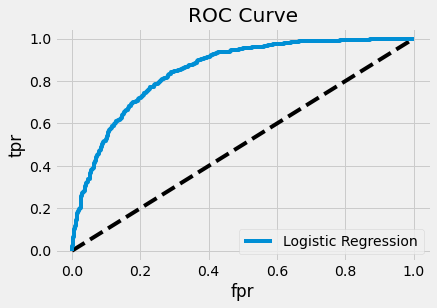

In [7]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();


In [8]:
metrics.roc_auc_score(y_test, y_proba_log)
y_proba_log_train = log.predict_proba(X_train)[:, 1]
metrics.roc_auc_score(y_train, y_proba_log_train)






0.842078173621252